In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import segyio
from segysak.segy import segy_loader, well_known_byte_locs, segy_header_scrape, segy_header_scan
from segysak import open_seisnc

import sys
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from datetime import datetime
import pandas as pd

import scipy.spatial as spatial
import itertools

from datetime import datetime

import open3d as o3d

from pyntcloud import PyntCloud

import pacmap
from skimage.color import rgb2hsv, hsv2rgb

from lshashpy3 import LSHash
from tqdm import notebook
import random

C:\Users\corla\anaconda3\envs\seis_int\lib\site-packages\segysak\segy\_segy_core.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
sys.path.append('../')
sys.path.append('../d2geo/attributes/')
from PointCloudSeismicInterpretation import PointCloudSeismicInterpretation
from PointCloudObjectRetrieval import PointCloudObjectRetrieval

# Load segy data

Download the 3D seismic from the F3-dataset https://terranubis.com/datainfo/F3-Demo-2020

Place it in data/F3_dataset folder

### Step 1 - Understand SEGY geometry / bytes location

In [5]:
t0 = datetime.now()
segy_file_path='../data/F3_dataset/Seismic_data.sgy'
trace_headers = segy_header_scrape(segy_file_path)
print('time: {}'.format(datetime.now()-t0))
trace_headers.shape


time: 0:00:54.248451


(600515, 89)

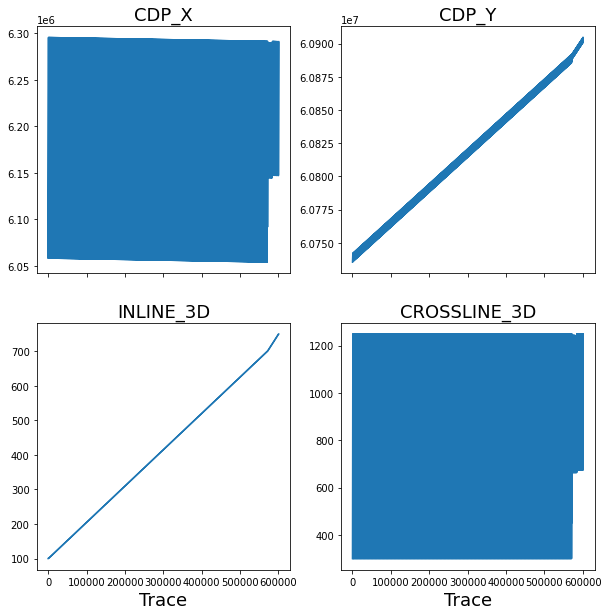

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharex=True)

for ax, prop in zip(axs.ravel(), ["CDP_X", "CDP_Y", "INLINE_3D", "CROSSLINE_3D"]):
    ax.plot(trace_headers[prop])
    ax.set_title(prop, fontdict={"fontsize":18})
    
for ax in axs[1,:]:
    ax.set_xlabel("Trace", fontdict={"fontsize":18})

In [7]:
scan = segy_header_scan(segy_file_path, max_traces_scan=2000)

In [9]:
with pd.option_context("display.max_rows", 100):
    display(scan)

,byte_loc,count,mean,std,min,25%,50%,75%,max
TRACE_SEQUENCE_LINE,1,2000.0,4.551015e+02,283.248107,1.0,201.75,451.5,701.25,951.0
TRACE_SEQUENCE_FILE,5,2000.0,1.000500e+03,577.494589,1.0,500.75,1000.5,1500.25,2000.0
FieldRecord,9,2000.0,1.005735e+02,0.585465,100.0,100.00,101.0,101.00,102.0
TraceNumber,13,2000.0,0.000000e+00,0.000000,0.0,0.00,0.0,0.00,0.0
EnergySourcePoint,17,2000.0,7.541015e+02,283.248107,300.0,500.75,750.5,1000.25,1250.0
CDP,21,2000.0,7.541015e+02,283.248107,300.0,500.75,750.5,1000.25,1250.0
CDP_TRACE,25,2000.0,0.000000e+00,0.000000,0.0,0.00,0.0,0.00,0.0
TraceIdentificationCode,29,2000.0,1.000000e+00,0.000000,1.0,1.00,1.0,1.00,1.0
NSummedTraces,31,2000.0,0.000000e+00,0.000000,0.0,0.00,0.0,0.00,0.0
NStackedTraces,33,2000.0,0.000000e+00,0.000000,0.0,0.00,0.0,0.00,0.0


In [10]:
t0 = datetime.now()
seis_ilBlock = segy_loader(
    segy_file_path, 
    iline=189,
    xline=193,
    cdpx=181,
    cdpy=185,
    vert_domain="TWT",
    data_type="AMP",
    head_df=trace_headers.copy(),
#     z_crop=[400, 900],
)
print("time {}".format(datetime.now()-t0))
seis_ilBlock

Loading as 3D
Fast direction is INLINE_3D



time 0:02:25.079318


<xarray.Dataset>
Dimensions:  (iline: 651, twt: 462, xline: 951)
Coordinates:
  * iline    (iline) uint16 100 101 102 103 104 105 ... 745 746 747 748 749 750
  * xline    (xline) uint16 300 301 302 303 304 305 ... 1246 1247 1248 1249 1250
  * twt      (twt) float64 4.0 8.0 12.0 16.0 ... 1.84e+03 1.844e+03 1.848e+03
    cdp_x    (iline, xline) float64 6.058e+05 6.059e+05 ... 6.291e+05 6.291e+05
    cdp_y    (iline, xline) float64 6.074e+06 6.074e+06 ... 6.09e+06 6.09e+06
Data variables:
    data     (iline, xline, twt) float32 0.0 0.0 0.0 0.0 ... 620.0 -915.0 -217.0
Attributes: (12/13)
    ns:                  None
    sample_rate:         4.0
    text:                C01  Created by:  (Tue Apr 07 16:03:31 2009)\nC02  F...
    measurement_system:  m
    d3_domain:           None
    epsg:                None
    ...                  ...
    corner_points_xy:    None
    source_file:         Seismic_data.sgy
    srd:                 None
    datatype:            None
    percentiles:         [-8475.60800015624, -8250.800733095133, -2737.793321...
    coord_scalar:        -10.0

In [11]:
#save seismic xarray to NetCDF4 file
seis_ilBlock.seisio.to_netcdf("../outputs/F3_dataset/F3_dataset_seismic.SEISNC")

In [12]:
#load seismic xarray from NetCDF4 file
if __name__ == '__main__':
    t0=datetime.now()
    seis_ilBlock = open_seisnc("../outputs/F3_dataset/F3_dataset_seismic.SEISNC")
    print('time {}'.format( datetime.now()-t0 ))
seis_ilBlock

time 0:00:00.008267


<xarray.Dataset>
Dimensions:  (iline: 651, twt: 462, xline: 951)
Coordinates:
    cdp_x    (iline, xline) float64 ...
    cdp_y    (iline, xline) float64 ...
  * iline    (iline) uint16 100 101 102 103 104 105 ... 745 746 747 748 749 750
  * twt      (twt) float64 4.0 8.0 12.0 16.0 ... 1.84e+03 1.844e+03 1.848e+03
  * xline    (xline) uint16 300 301 302 303 304 305 ... 1246 1247 1248 1249 1250
Data variables:
    data     (iline, xline, twt) float32 ...
Attributes: (12/13)
    coord_scalar:        -10.0
    measurement_system:  m
    percentiles:         [-8475.60800016 -8250.8007331  -2737.79332148   -43....
    sample_rate:         4.0
    source_file:         Seismic_data.sgy
    text:                C01  Created by:  (Tue Apr 07 16:03:31 2009)\nC02  F...
    ...                  ...
    d3_domain:           None
    epsg:                None
    corner_points:       None
    corner_points_xy:    None
    srd:                 None
    datatype:            None

In [13]:
seis_ilBlock.data.shape

(651, 951, 462)

In [14]:
np.percentile(seis_ilBlock.data, 99)

6517.0

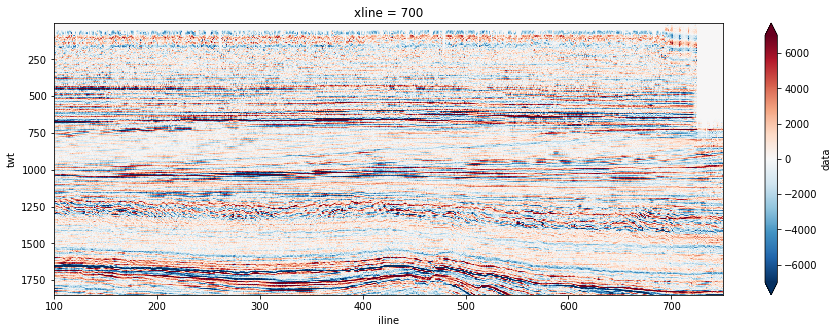

In [15]:
_ = seis_ilBlock.sel(xline=700,).data.T.plot(yincrease=False, figsize=(15,5), vmax=7000)
# plt.plot([5000,6000], [2500,2500,], '-', 'black')
# plt.show()

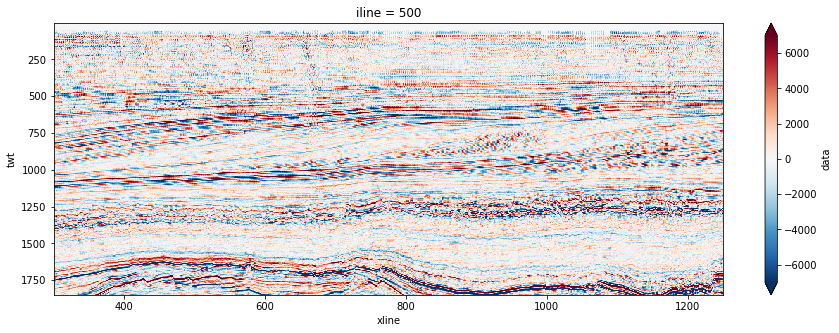

In [16]:
_ = seis_ilBlock.sel(iline=500,).data.T.plot(yincrease=False, figsize=(15,5), vmax=7000)

## Point cloud extraction and segmentation

In [17]:
if __name__ == '__main__':
    t0=datetime.now()
    pointCloudInterpretor = PointCloudSeismicInterpretation(seismic_array = np.array(seis_ilBlock.data[:, :951]), ampv95p=7000)
    pointCloudInterpretor.extrema_extraction_dask()
    print('time {}'.format( datetime.now()-t0 ))

point cloud shape (57984675, 4)
Point cloud created -  57984675 points - time to execute: 0:02:00.576157
time 0:02:00.798652


In [18]:
if __name__ == '__main__':
    t0=datetime.now()
    pointCloudInterpretor.filter_point_cloud_with_semblance(kernel=(3,3,9), thr=0.85, in_place=True)
    print('time {}'.format( datetime.now()-t0 ))

Semblance attribute computed - time to execute: 0:00:32.734492
Semblance point cloud extracted - time to execute: 0:00:00.616250
Applied semblance filter in place -  21158406 points - time to execute: 0:00:00.862093
time 0:00:34.222978


In [19]:
if __name__ == '__main__':
    t0=datetime.now()
    pointCloudInterpretor.filter_point_cloud_with_amplitude(thr=0.20, in_place=True)
    print('time {}'.format( datetime.now()-t0 ))

Applied amplitude filter in place -  15537418 points - time to execute: 0:00:00.517316
time 0:00:00.517316


In [42]:
#save numpy arrays
if __name__ == '__main__':
    t0=datetime.now()
    np.save('../outputs/F3_dataset/point_cloud_F3_dataset.npy', pointCloudInterpretor.point_cloud)
    np.save('../outputs/F3_dataset/semblance_point_cloud_F3_dataset.npy', pointCloudInterpretor.semblance_point_cloud)
    np.save('../outputs/F3_dataset/amplitude_point_cloud_F3_dataset.npy', pointCloudInterpretor.amplitude_point_cloud)
    print('File saved {}'.format(datetime.now()-t0))

File saved 0:00:00.453091


In [4]:
#load point cloud from numpy arrays
if __name__ == '__main__':
    t0=datetime.now()
    pointCloudInterpretor = PointCloudSeismicInterpretation(seismic_array = np.array([]), ampv95p=7000)
    pointCloudInterpretor.point_cloud = np.load('../outputs/F3_dataset/point_cloud_F3_dataset.npy', mmap_mode='r')
    pointCloudInterpretor.semblance_point_cloud = np.load('../outputs/F3_dataset/semblance_point_cloud_F3_dataset.npy', mmap_mode='r')
    pointCloudInterpretor.amplitude_point_cloud = np.load('../outputs/F3_dataset/amplitude_point_cloud_F3_dataset.npy', mmap_mode='r')
    print(pointCloudInterpretor.point_cloud.shape, pointCloudInterpretor.semblance_point_cloud.shape, pointCloudInterpretor.amplitude_point_cloud.shape)
    print('File loaded {}'.format(datetime.now()-t0))

(15537418, 3) (15537418,) (15537418,)
File loaded 0:00:00.024562


In [20]:
#create 3D orientation object
[a,b,c] = [
        pointCloudInterpretor.point_cloud[:,0].min(), 
        pointCloudInterpretor.point_cloud[:,1].min(), 
        pointCloudInterpretor.point_cloud[:,2].min(), 
    ]
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=100, origin=[a,b,c])

In [21]:
#create a point cloud open3D object and plot colored by amplitude with open3D viewer
if __name__ == '__main__':
    t0 = datetime.now()
    z_factor = 1
    pcd_pyntcloud = PyntCloud(pd.DataFrame(data={'x':pointCloudInterpretor.point_cloud.T[0], 
                                                 'y':pointCloudInterpretor.point_cloud.T[1], 
                                                 'z':pointCloudInterpretor.point_cloud.T[2]*z_factor, 
                                                 'amplitude':pointCloudInterpretor.amplitude_point_cloud})[:])
    pcd_o3d = pcd_pyntcloud.to_instance("open3d", mesh=False)
    print('Time to create object {}'.format(datetime.now() - t0))

Time to create object 0:00:12.445821


In [22]:
#plot point cloud colored by amplitude with open3D viewer
if __name__ == '__main__':
    colors = plt.get_cmap("Reds")(pointCloudInterpretor.amplitude_point_cloud)
#     colors = plt.get_cmap("Greys_r")(pointCloudInterpretor.semblance_point_cloud)
    pcd_o3d.colors = o3d.utility.Vector3dVector(colors[:, :3])
    o3d.visualization.draw_geometries([pcd_o3d.random_down_sample(0.4)],)
#     #downsampling from voxels
#     o3d.visualization.draw_geometries([pcd_o3d.voxel_down_sample(voxel_size=10.)],)

In [23]:
# #segmentation of the point cloud
# if __name__ == '__main__':
#     t0=datetime.now()
#     pointCloudInterpretor.DBSCAN_interpretation(eps=2, min_samples=9, z_factor=1)
#     print('time {}'.format( datetime.now()-t0 ))

In [24]:
#with vertical exageration
if __name__ == '__main__':
    t0 = datetime.now()
    with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
        labels = np.array(
            pcd_o3d.cluster_dbscan(eps=2, min_points=8, print_progress=True))
    print('Segmentation time {}'.format(datetime.now() - t0))

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 92169
Segmentation time 0:00:49.506782


In [47]:
#save cluster labels to numpy arrays
if __name__ == '__main__':
    t0=datetime.now()
    np.save('../outputs/F3_dataset/labels_point_cloud_F3_dataset.npy', labels)
    print('File saved {}'.format(datetime.now()-t0))

File saved 0:00:00.078066


In [14]:
#laod cluster labels
if __name__ == '__main__':
    t0=datetime.now()
    labels = np.load('../outputs/F3_dataset/labels_point_cloud_F3_dataset.npy', mmap_mode='r')
    print(labels.shape)
    print('File loaded {}'.format(datetime.now()-t0))

(15537418,)
File loaded 0:00:00.024622


In [25]:
pointCloudInterpretor.point_cloud.shape, pointCloudInterpretor.amplitude_point_cloud.shape, labels.shape

((15537418, 3), (15537418,), (15537418,))

In [26]:
## visualisation
pcd_o3d = o3d.geometry.PointCloud()
pcd_o3d.points = o3d.utility.Vector3dVector(pointCloudInterpretor.point_cloud)

#color by cluster with random color
max_label = labels.max()
cmap = ListedColormap ( np.random.rand ( max_label+1, 3))
colors = cmap(labels+1)
colors[labels < 0] = 0

colors = rgb2hsv(colors[:,:3])
colors[:,-1] = pointCloudInterpretor.amplitude_point_cloud
colors = hsv2rgb(colors[:,:3])

pcd_o3d.colors = o3d.utility.Vector3dVector(colors[:, :3])

In [27]:
o3d.visualization.draw_geometries([pcd_o3d.random_down_sample(0.6)],)

In [28]:
#visualisation fitering noise and small clusters
#noise filter
noise_filter = np.isin(labels, [-1], invert=True)

#small cluster filter
min_display = 1000
(unique, counts) = np.unique(labels[noise_filter], return_counts=True)
selected_clusters = unique[counts >= min_display]
print('number of selected clusters: {}'.format(len(selected_clusters)))
small_cluster_filter = np.isin(labels[noise_filter], selected_clusters)

# #color by cluster with random color
# max_label = labels_crop.max()
# cmap = ListedColormap ( np.random.rand ( max_label+1, 3))
# colors = cmap(labels_crop[noise_filter][small_cluster_filter]+1)
# # colors[labels_crop[noise_filter][small_cluster_filter]  < 0] = 0

pcd_o3d_big = o3d.geometry.PointCloud()
pcd_o3d_big.points = o3d.utility.Vector3dVector(pointCloudInterpretor.point_cloud[noise_filter][small_cluster_filter][:, :3])

#color by cluster with random color
max_label = labels[noise_filter][small_cluster_filter].max()
cmap = ListedColormap ( np.random.rand ( max_label+1, 3))
colors = cmap(labels[noise_filter][small_cluster_filter]+1)
colors[labels[noise_filter][small_cluster_filter] < 0] = 0

colors = rgb2hsv(colors[:,:3])
colors[:,-1] = pointCloudInterpretor.amplitude_point_cloud[noise_filter][small_cluster_filter]
colors = hsv2rgb(colors[:,:3])


pcd_o3d_big.colors = o3d.utility.Vector3dVector(colors[:, :3])

number of selected clusters: 613


In [29]:
o3d.visualization.draw_geometries([pcd_o3d_big.random_down_sample(0.7), mesh_frame])

In [30]:
def custom_draw_geometry_with_rotation(pcd, mesh_frame):

    def rotate_view(vis):
        ctr = vis.get_view_control()
        ctr.rotate(5.0, 0.0)
        return False
    o3d.visualization.draw_geometries_with_animation_callback([pcd, mesh_frame],
                                                              rotate_view)

In [31]:
custom_draw_geometry_with_rotation(pcd_o3d_big.random_down_sample(0.5), mesh_frame)

## Object detection

### Feature extraction

In [32]:
pcd = np.zeros((len(pointCloudInterpretor.point_cloud),4))
pcd[:,:3] = pointCloudInterpretor.point_cloud[:,:]
pcd[:,3]= pointCloudInterpretor.amplitude_point_cloud
FeatureExtractor = PointCloudObjectRetrieval(
    pcd[noise_filter][np.isin(labels[noise_filter], selected_clusters)], 
    pointCloudInterpretor.semblance_point_cloud[noise_filter][np.isin(labels[noise_filter], selected_clusters)],
    labels[noise_filter][np.isin(labels[noise_filter], selected_clusters)]
)
standardized_featureDF = FeatureExtractor.get_features(selected_clusters)

time: 0:00:49.357205


In [33]:
standardized_featureDF.round(3).head(3)

,nPoints,amplitudeMean,semblanceMean,ZeboudjDistance,outlineRatio,lambda1,lambda2,lambda3,linearity,slope,slopeMinAxis,orientation,rZHigh,rZLow
segmentID,,,,,,,,,,,,,,
0,-0.129,0.344,-0.690,1.759,-0.901,-0.310,-0.150,-0.108,0.088,-0.095,-0.116,0.347,-0.300,-1.455
1,-0.027,1.955,1.458,-1.142,-1.945,0.035,-0.050,-0.108,0.093,-0.095,-0.116,-0.022,0.179,-0.635
2,-0.029,2.009,1.663,-0.754,-1.984,-0.021,-0.022,-0.108,0.091,-0.095,-0.116,-0.066,0.230,-0.407


### Binary hashing and similar object retrieval

In [34]:
##================= Binary Hashing images - Locality Sensitive Hashing =================

selected_features = [
    "amplitudeMean", 
    "semblanceMean", 
    "ZeboudjDistance", 
    "nPoints", 
    "outlineRatio", 
#     "lambda1", 
#     "lambda2", 
#     "lambda3", 
    "linearity",
    "slope", 
    "slopeMinAxis", 
    "orientation", 
#     "rZHigh", 
#     "rZLow",
]

### LSH on all the selected segments
feature_dict = dict(zip(standardized_featureDF.index, standardized_featureDF[selected_features].values))

### params
k = 7 # hash size
L = 20  # number of tables
d = len(selected_features) #2048 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

for ID, vec in notebook.tqdm(feature_dict.items()):
    lsh.index(vec.flatten(), extra_data=ID)

In [35]:
def plot_similar_items(features, lsh_variable, pcd, labels, n_items=5):
    """plot n_items images given a feature tensor"""
    response = lsh_variable.query(features, 
                     num_results=n_items, distance_func='hamming')
#     for i in range(len(response)):
#         print(response[i-1][0][1])
#     return
    n_responses = len(response)
    print("number of responses {}".format(n_responses))
    columns = 3
    rows = int(np.ceil(n_responses+1/columns))
    fig=plt.figure(figsize=(15, 5*rows))
    segments = []
    for i in range(1, columns*rows +1):
        if i<n_responses+1:
            pc_to_display=pcd[np.isin(labels, response[i-1][0][1])]
            X = pc_to_display[:,0].astype(int)
            Y = pc_to_display[:,1].astype(int)
            #convert 2d projection to image
            #shift X and Y coordinate to 0 origin
            X_shift = X-min(X); Y_shift = Y-min(Y)
            X_shift.astype(int); Y_shift.astype(int)
            Img = np.zeros((max(X_shift)+1, max(Y_shift)+1))
            #         sln_binary = np.zeros((max(Xsln_shift)+1, max(Ysln_shift)+1))
            #         Img[X_shift, Y_shift] = Ampcolor
            Img[X_shift, Y_shift] = 255
            Img=Img.astype('uint8')
#             img = cv.imread(response[i-1][0][1])
            fig.add_subplot(rows, columns, i)
            plt.imshow(Img)
            plt.title("cluster : {}".format(response[i-1][0][1]))
            segments.append(response[i-1][0][1])
    plt.show()
    return segments

In [36]:
#identify id of particular segment to give as example
for icluster in np.unique(labels[np.isin(labels, selected_clusters)]):
    print("display cluster {}".format(icluster))
    pcd_o3d_oneCl = o3d.geometry.PointCloud()
    pcd_o3d_oneCl.points = o3d.utility.Vector3dVector(pcd[np.isin(labels, [icluster])][:,:3])
    #color by amplitude
    colors = plt.get_cmap("Reds")(pcd[np.isin(labels, [icluster])][:,3])
    pcd_o3d_oneCl.colors = o3d.utility.Vector3dVector(colors[:, :3])
    o3d.visualization.draw_geometries([pcd_o3d_oneCl.random_down_sample(1.)])

display cluster 0
display cluster 1
display cluster 2
display cluster 4
display cluster 7
display cluster 8
display cluster 9
display cluster 10
display cluster 11
display cluster 21
display cluster 23
display cluster 24
display cluster 25
display cluster 26
display cluster 28
display cluster 30
display cluster 63
display cluster 78
display cluster 95
display cluster 153
display cluster 155
display cluster 157
display cluster 211
display cluster 248
display cluster 258
display cluster 269
display cluster 337
display cluster 356
display cluster 370
display cluster 414
display cluster 510
display cluster 519
display cluster 626
display cluster 651
display cluster 678
display cluster 683
display cluster 733
display cluster 745
display cluster 749
display cluster 751
display cluster 761
display cluster 787
display cluster 854
display cluster 866
display cluster 879
display cluster 939
display cluster 955
display cluster 982
display cluster 996
display cluster 1014


KeyboardInterrupt: 

number of responses 150


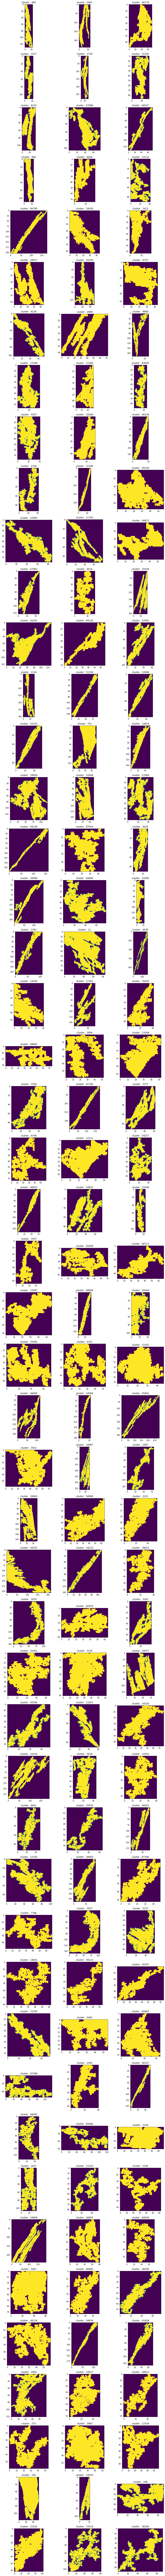

In [38]:
# idx = random.randint(0, len(list(feature_dict.keys()))-1)
input_segment = 982 #[996, 982]
n_segments = 150
# print('Segment number {} and its {}-closest segments in the database'.format(list(feature_dict.keys())[idx], n_segments-1))
# get_similar_items(feature_dict[list(feature_dict.keys())[idx]].flatten(), lsh, n_segments)
segments = plot_similar_items(
#     feature_dict[list(feature_dict.keys())[idx]].flatten(), 
    feature_dict[input_segment].flatten(),
    lsh, 
    pcd[noise_filter],
    labels[noise_filter],
    n_segments,
)

In [39]:
point_cloud_responses = pcd[noise_filter][np.isin(labels[noise_filter], segments)]
labels_responses = labels[noise_filter][np.isin(labels[noise_filter], segments)]
#Visualize n-closest segments from point cloud
pcd_o3d_responses = o3d.geometry.PointCloud()
pcd_o3d_responses.points = o3d.utility.Vector3dVector(point_cloud_responses[:,:3])

In [40]:
#plot in 3D the closest segments
# color with segmentation labels, random colors
max_label = labels_responses.max()
if max_label==-1:
    cmap = ListedColormap ( np.array([[0,0,0]]) )
elif -1 not in labels_responses:
    cmap = ListedColormap ( (np.random.rand( max_label+1, 3)) )
else:
    cmap = ListedColormap ( np.concatenate((np.array([[0,0,0]]), np.random.rand( max_label+1, 3)), axis=0))
colors = cmap(labels_responses+1)

colors = rgb2hsv(colors[:,:3])
colors[:,-1] = point_cloud_responses[:,3]
colors = hsv2rgb(colors[:,:3])

pcd_o3d_responses.colors = o3d.utility.Vector3dVector(colors[:, :3])

In [41]:
o3d.visualization.draw_geometries([pcd_o3d_responses.random_down_sample(1), mesh_frame],)